<a href="https://colab.research.google.com/github/atanuGuin/Computer_Vision_Coursework/blob/CV2020/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Car Classification using Transfer Learning and Finetuning pre-trained model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#importing the necessary libraries

In [3]:


import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import cv2
import copy
import natsort
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

#set the device to cuda

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#setting the train and test load directory
#load the csv files

In [6]:
train_dir = '/content/drive/MyDrive/Task/train'

df_train = pd.read_csv('/content/drive/MyDrive/Task/train.csv')
car_classes = pd.read_csv('/content/drive/MyDrive/Task/class_names.csv',header= None)

In [7]:
df_train

,image_name,label
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106
...,...,...
8139,08140.jpg,78
8140,08141.jpg,196
8141,08142.jpg,163
8142,08143.jpg,112


#checking the sample for each class

In [8]:

sample_per_class = df_train.groupby("label")['image_name'].count()

In [9]:
print('Max Sample: ',sample_per_class.max())
print('Median Sample: ',sample_per_class.median())
print('Min Sample: ',sample_per_class.min())

Max Sample:  68
Median Sample:  42.0
Min Sample:  24


#plot for training sample for each class

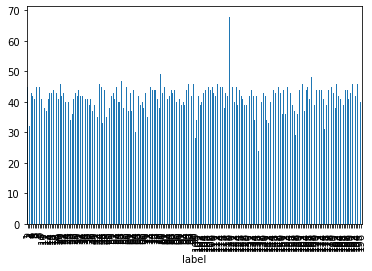

In [10]:

sample_per_class.plot.bar()

In [11]:
car_classes

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


#custom dataset loader 

In [12]:

class CustomDataSet(Dataset):
    def __init__(self, main_dir,input_size,df,car_classes, file,transform = None):
        self.main_dir = main_dir
        self.input_size = input_size
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        self.df = df
        self.car_classes = car_classes
        self.file = file

    def __len__(self):
        return len(self.total_imgs)
    
    def __readimages__(self,img_loc):
        image = Image.open(img_loc).convert('RGB') 
        image = image.resize((self.input_size,self.input_size))
        return self.transform(image)


    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        # label = (self.df[self.df['image_name'] == self.total_imgs[idx]]['label'].values)
        if self.file=='train':
          data = {
            'idx'   : img_loc.split('/')[-1],
            'image' : self.__readimages__(img_loc),
            'label' : (self.df[self.df['image_name'] == self.total_imgs[idx]]['label'].values) - 1
          }
        elif self.file =='test':
           data = {
            'idx'   : img_loc.split('/')[-1],
            'image' : self.__readimages__(img_loc),
            'label' : (self.df[self.df['image_name'] == self.total_imgs[idx]]['label'].values) - 1
          }
        return data

In [13]:
input_size = 224
tbatch_size = 128
batch_size = 32
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



In [14]:
trainset = CustomDataSet(train_dir,input_size,df_train,car_classes,'train',train_transform)

In [15]:
def split_indices(n, val_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

#random sampling train and validation loader

In [16]:

val_pct = 0.1
rand_seed = 42
train_indices, val_indices = split_indices(len(trainset), val_pct, rand_seed)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [17]:
#train and validation dataloader
train_loader = DataLoader(trainset , batch_size=tbatch_size, shuffle=False, 
                               num_workers=1,sampler=train_sampler, drop_last=False)
valid_loader = DataLoader(trainset , batch_size=tbatch_size, shuffle=False, 
                               num_workers=1,sampler=valid_sampler, drop_last=False)

visualize part of the dataset

In [18]:
def show_img(im, figsize=None, ax=None):
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

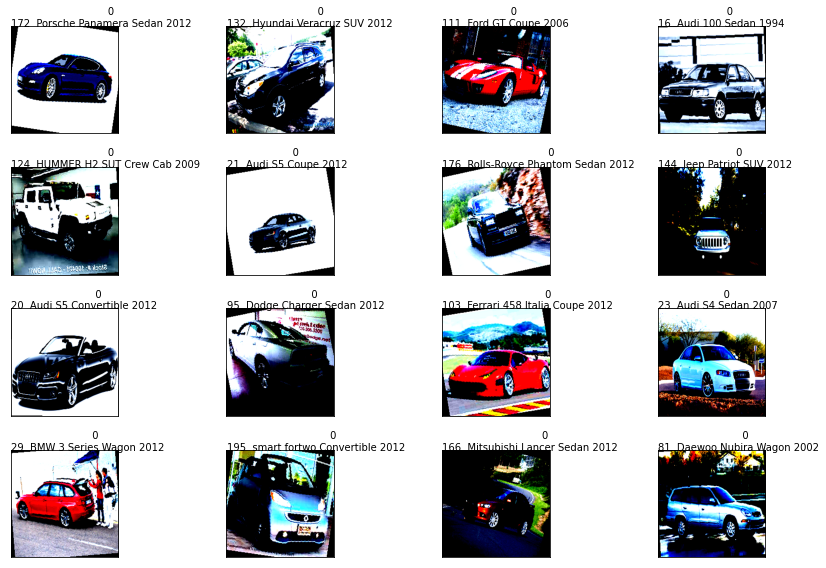

In [19]:
data = next(iter(train_loader))
idx, image,klass = data['idx'], data['image'], data['label']
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=image[i].numpy().transpose((1, 2, 0))
    b = car_classes.loc[klass[i]]
    ax = show_img(ima, ax=ax)
    ax.text(0, 0, str(b))
    # draw_text(ax, (0,0), b)
plt.tight_layout()

#pretrained ResNet50 model for Transfer Learning and FIne Tuning on the training dataset

In [20]:

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
hidden_size = 1024

#added 2 layer FC network for classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs,hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size,196)
)
# model.fc = nn.Linear(num_ftrs, 196)
model.to('cuda')


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Macro - F1 Score Metric

In [21]:

class F1Score:
    def __init__(self, average: str = 'macro'):
        self.average = average

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int):
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)
            if self.average == 'macro':
                f1_score += f1
        if self.average == 'macro':
          f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

#Accuracy based on Macro F1 score

In [22]:

def accuracy(outputs,labels):
  _,preds =  torch.max(outputs,dim=1)
  f1_metric = F1Score()
  return f1_metric(preds,labels)

In [23]:
def validation_epoch_end(outputs):
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item() }
    
def epoch_end(epoch, result1, result2):
    print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result1['val_loss'], result1['val_acc']))
    print("val_loss: {:.4f}, val_acc: {:.4f}".format(result2['val_loss'], result2['val_acc']))

#training module

In [24]:


def train_model(model,train_loader,valid_loader,criterion,epochs,opt,lrscheduler):
  history = []  

  best_model_params = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    epoch_stats = []
    train_stats = []
    train_acc = 0.0
    #For Training
    model.train()
    for batch in tqdm(train_loader):
      images,labels = batch['image'],batch['label']
      images = images.to('cuda') 
      labels = labels.to('cuda') 
      with torch.set_grad_enabled(True):
        opt.zero_grad()

        outputs = model(images)
        loss = criterion(outputs,labels.flatten())
        running_loss += loss.item()
        curr_acc = accuracy(outputs,labels.flatten())
        train_stats.append({'val_loss' : loss, 'val_acc' : curr_acc })
        loss.backward()
        opt.step()
    train_result = validation_epoch_end(train_stats)
    

    #For validation
    model.eval()
    for batch in tqdm(valid_loader):
      images,labels = batch['image'],batch['label']
      images = images.to('cuda') 
      labels = labels.to('cuda') 
      with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs,labels.flatten())
        acc = accuracy(outputs,labels.flatten())
        epoch_stats.append({'val_loss' : loss, 'val_acc' : acc })

    valid_result = validation_epoch_end(epoch_stats)
    
    lrscheduler.step(running_loss)

    ##loading the best model based on validation accuracy
    if best_acc < valid_result['val_acc']:
      best_model_params = copy.deepcopy(model.state_dict())
      best_acc = valid_result['val_acc']

    if(epoch+1)%1==0:
      epoch_end(epoch+1,train_result, valid_result)
      print('Best Validation Acc: {:.4f} '.format(best_acc))
      # print('\n')

    history.append(valid_result)

  model.load_state_dict(best_model_params)
  return model, history    


#defining cross-entropy loss for classification, SGD optimizer and LR scheduler 

In [25]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=1,verbose=True)

In [26]:
epoch = 25

#Training the model 

In [27]:

model,history = train_model(model,train_loader,valid_loader,criterion,epoch,optimizer,lrscheduler)


Epoch [1], train_loss: 5.2355, train_acc: 0.0026
val_loss: 5.0913, val_acc: 0.0039
Best Validation Acc: 0.0039 



Epoch [2], train_loss: 4.6413, train_acc: 0.0106
val_loss: 4.1329, val_acc: 0.0191
Best Validation Acc: 0.0191 



Epoch [3], train_loss: 3.4990, train_acc: 0.0529
val_loss: 3.0512, val_acc: 0.0700
Best Validation Acc: 0.0700 



Epoch [4], train_loss: 2.4717, train_acc: 0.1325
val_loss: 2.4843, val_acc: 0.1230
Best Validation Acc: 0.1230 



Epoch [5], train_loss: 1.6951, train_acc: 0.2206
val_loss: 1.7370, val_acc: 0.2165
Best Validation Acc: 0.2165 



Epoch [6], train_loss: 1.1478, train_acc: 0.2848
val_loss: 1.8043, val_acc: 0.1980
Best Validation Acc: 0.2165 



Epoch [7], train_loss: 0.7959, train_acc: 0.3435
val_loss: 1.3573, val_acc: 0.2242
Best Validation Acc: 0.2242 



Epoch [8], train_loss: 0.5651, train_acc: 0.3747
val_loss: 1.2118, val_acc: 0.2553
Best Validation Acc: 0.2553 



Epoch [9], train_loss: 0.4179, train_acc: 0.3997
val_loss: 1.3861, val_acc: 0.2346
Best Validation Acc: 0.2553 



Epoch [10], train_loss: 0.3231, train_acc: 0.4193
val_loss: 1.1250, val_acc: 0.2756
Best Validation Acc: 0.2756 



Epoch [11], train_loss: 0.2730, train_acc: 0.4212
val_loss: 1.1252, val_acc: 0.2714
Best Validation Acc: 0.2756 



Epoch [12], train_loss: 0.2118, train_acc: 0.4406
val_loss: 1.0497, val_acc: 0.3072
Best Validation Acc: 0.3072 



Epoch [13], train_loss: 0.1513, train_acc: 0.4467
val_loss: 1.0217, val_acc: 0.2752
Best Validation Acc: 0.3072 



Epoch [14], train_loss: 0.1080, train_acc: 0.4568
val_loss: 0.9354, val_acc: 0.3335
Best Validation Acc: 0.3335 



Epoch [15], train_loss: 0.0857, train_acc: 0.4677
val_loss: 0.9281, val_acc: 0.2995
Best Validation Acc: 0.3335 



Epoch [16], train_loss: 0.0725, train_acc: 0.4645
val_loss: 0.8469, val_acc: 0.3225
Best Validation Acc: 0.3335 



Epoch [17], train_loss: 0.0587, train_acc: 0.4624
val_loss: 0.8654, val_acc: 0.3459
Best Validation Acc: 0.3459 



Epoch [18], train_loss: 0.0524, train_acc: 0.4635
val_loss: 0.9348, val_acc: 0.3329
Best Validation Acc: 0.3459 



Epoch [19], train_loss: 0.0405, train_acc: 0.4684
val_loss: 0.9640, val_acc: 0.2965
Best Validation Acc: 0.3459 



Epoch [20], train_loss: 0.0409, train_acc: 0.4624
val_loss: 0.9392, val_acc: 0.3257
Best Validation Acc: 0.3459 



Epoch [21], train_loss: 0.0398, train_acc: 0.4691
val_loss: 0.8975, val_acc: 0.3324
Best Validation Acc: 0.3459 



Epoch [22], train_loss: 0.0327, train_acc: 0.4761
val_loss: 0.8681, val_acc: 0.3269
Best Validation Acc: 0.3459 



Epoch [23], train_loss: 0.0287, train_acc: 0.4711
val_loss: 0.8664, val_acc: 0.3199
Best Validation Acc: 0.3459 



Epoch [24], train_loss: 0.0238, train_acc: 0.4743
val_loss: 0.8343, val_acc: 0.3253
Best Validation Acc: 0.3459 



Epoch [25], train_loss: 0.0196, train_acc: 0.4735
val_loss: 0.8462, val_acc: 0.3271
Best Validation Acc: 0.3459 



#save the model state directory

In [28]:
   
   torch.save(model.state_dict(),'/content/drive/MyDrive/Task/models/resnet50.pth')

# load saved model.state_dict()

In [29]:
model2 = models.resnet50(pretrained=True)
num_ftrs = model2.fc.in_features
# print(num_ftrs)
hidden_size = 1024
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs,hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size,196)
)

model2.to('cuda')



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
def evaluate(model,test_loader,criterion):
#For validation
  model.eval()
  epoch_stats = []
  image_names = []
  output_label = []
  for batch in test_loader:
   idx, images =batch['idx'], batch['image']
   image_names.extend(idx)
   images = images.to('cuda') 
  #  labels = labels.to('cuda') 
   with torch.no_grad():
     outputs = model(images)
     _,preds =  torch.max(outputs,dim=1)
    #  loss = criterion(outputs,labels.flatten())
    #  preds,acc = accuracy(outputs,labels)
    #  epoch_stats.append({'val_loss' : loss, 'val_acc' : acc })
     output_label.extend(preds.cpu().tolist())
  return image_names,output_label


### ***Change the required paths before evaluating test dataset***

In [31]:
#change the path to model file here
model2.load_state_dict(torch.load('/content/drive/MyDrive/Task/models/resnet50.pth'))

#change the test_dir 
test_dir = '/content/drive/MyDrive/Task/test'

#change the path to test.csv
df_test = pd.read_csv('/content/drive/MyDrive/Task/test.csv')



In [32]:
#normalize test dataset and convert it into tensor
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#create test dataset
testset = CustomDataSet(test_dir,input_size,df_test,car_classes,'test',test_transform)

#Test data loader
test_loader = DataLoader(testset , batch_size=batch_size, shuffle=False, 
                               num_workers=1, drop_last=False)

evaluate on test dataset

In [33]:
image,outputs = evaluate(model2,test_loader,criterion)

creating submission csv

In [34]:
submission = pd.DataFrame({'image_name':image,'label':outputs})
submission.to_csv('/content/drive/MyDrive/Task/models/submission.csv', index=False)